# Vergleich zweier Graphen

Korrelation zwischen zwei Variablen
--> numpy

In [1]:
import numpy as np

## Test mit Fußgängern und Inzidenzen (Münchens)

### Dictionary mit Fußgängern und Fällen nach Datum

In [2]:
from pymongo import MongoClient
import datetime as dt

client = MongoClient('mongodb://localhost:27017/')

pedestrians = client.pedcov.pedestrians
incidences = client.pedcov.incidences

# dic:  {date: [pedstrians, covid count]}
dic = {}

# pedestrians (only München)
for row in pedestrians.aggregate(
    [{
    "$match": {"location": "Kaufingerstraße, München"}
    }]):
    if row['time of measurement'] != 'time of me':
        date = dt.datetime.strptime(row['time of measurement'], '%Y-%m-%d').date()
        dic[date] = [int(row['pedestrians count'])]


# incidences (only München, NeuerFall in (0, 1)) -> aggregiert nach Meldedatum (Summe Fälle)
for row in incidences.aggregate(
    [{
        "$match": 
            {"$and":
             [
                 {"Landkreis": "SK München"},
                 {"$or": [{"Neuer Fall": "0"}, {"Neuer Fall": "1"}]}
             ]
            }
    },
    {
        "$group": {"_id": "$Meldedatum","Fälle": {"$sum": "$Anzahl Fall"}}
    }]):
    date = dt.datetime.strptime(row['_id'], '%Y-%m-%d').date()
    dic[date].append(int(row['Fälle']))

# add 0 where no incidences
d = {}
for k in dic:
    l = dic[k]
    if len(l) == 1:
        l.append(0)
    d[k] = l

dic = d

dic

{datetime.date(2020, 1, 1): [61896, 0],
 datetime.date(2020, 1, 2): [128865, 0],
 datetime.date(2020, 1, 3): [123737, 0],
 datetime.date(2020, 1, 4): [118112, 0],
 datetime.date(2020, 1, 5): [35286, 0],
 datetime.date(2020, 1, 6): [33596, 0],
 datetime.date(2020, 1, 7): [56079, 0],
 datetime.date(2020, 1, 8): [62615, 0],
 datetime.date(2020, 1, 9): [69690, 0],
 datetime.date(2020, 1, 10): [79217, 0],
 datetime.date(2020, 1, 11): [114360, 0],
 datetime.date(2020, 1, 12): [29366, 0],
 datetime.date(2020, 1, 13): [60058, 0],
 datetime.date(2020, 1, 14): [61250, 0],
 datetime.date(2020, 1, 15): [63147, 0],
 datetime.date(2020, 1, 16): [62923, 0],
 datetime.date(2020, 1, 17): [78998, 0],
 datetime.date(2020, 1, 18): [102862, 0],
 datetime.date(2020, 1, 19): [24408, 0],
 datetime.date(2020, 1, 20): [54335, 0],
 datetime.date(2020, 1, 21): [54053, 0],
 datetime.date(2020, 1, 22): [54618, 0],
 datetime.date(2020, 1, 23): [55530, 0],
 datetime.date(2020, 1, 24): [79833, 0],
 datetime.date(2020,

### Umwandlung der Fälle in Inzidenzen

Funktion to_incidences nimmt ein dictionary der Form d = {date: fälle} 

und erstellt ein passendes dictionary res = {date: incidence}

In [3]:
def to_incidences(d, einwohner):
    res = {}
    
    # add the first 7 days a 0
    cur_date = dt.date(2020,1,1)
    for i in range(7):
        res[cur_date] = 0
        cur_date += dt.timedelta(days = 1)
    
    for date in d:
        if(date >= dt.date(2020,12,25)):
            break
            
        fälle = 0
        cur_date = date
        fälle += d[cur_date]
        for delta in range(7):
            cur_date += dt.timedelta(days = 1)
            fälle += d[cur_date]
        
        incidence = (fälle*100000)/einwohner
        res[cur_date] = round(incidence)
    
    return res

In [4]:
d = {k:dic[k][1] for k in dic}
einwohner = 1488202
res = to_incidences(d, einwohner)
res

{datetime.date(2020, 1, 1): 0,
 datetime.date(2020, 1, 2): 0,
 datetime.date(2020, 1, 3): 0,
 datetime.date(2020, 1, 4): 0,
 datetime.date(2020, 1, 5): 0,
 datetime.date(2020, 1, 6): 0,
 datetime.date(2020, 1, 7): 0,
 datetime.date(2020, 1, 8): 0,
 datetime.date(2020, 1, 9): 0,
 datetime.date(2020, 1, 10): 0,
 datetime.date(2020, 1, 11): 0,
 datetime.date(2020, 1, 12): 0,
 datetime.date(2020, 1, 13): 0,
 datetime.date(2020, 1, 14): 0,
 datetime.date(2020, 1, 15): 0,
 datetime.date(2020, 1, 16): 0,
 datetime.date(2020, 1, 17): 0,
 datetime.date(2020, 1, 18): 0,
 datetime.date(2020, 1, 19): 0,
 datetime.date(2020, 1, 20): 0,
 datetime.date(2020, 1, 21): 0,
 datetime.date(2020, 1, 22): 0,
 datetime.date(2020, 1, 23): 0,
 datetime.date(2020, 1, 24): 0,
 datetime.date(2020, 1, 25): 0,
 datetime.date(2020, 1, 26): 0,
 datetime.date(2020, 1, 27): 0,
 datetime.date(2020, 1, 28): 0,
 datetime.date(2020, 1, 29): 0,
 datetime.date(2020, 1, 30): 0,
 datetime.date(2020, 1, 31): 0,
 datetime.date(20

### Berechnung der Korrelation

In [5]:
peds = [p for p,i in dic.values()]
fälle = [f for p,f in dic.values()]
incs = [i for i in res.values()]
dates = dic[date]
dates

[54462, 22]

# Grundlegende Funktionen zur Betrachtung von spezifischen Zeiträumen

Im Folgenden geht es um die Betrachtung von Fußgängerzahlen und Coronainzidenzen während spezifischen Zeiträumen im Jahr 2020. Dazu zählen Lockdowns, Ferienzeiten oder Feste wie Fastnacht. 
Dazu werden drei Funktionen definiert:

1. Die Funktionen calcDay(date) nimmt ein Datum im Format "dd-mm-yyyy" entgegen und gibt zurück, der wie vielte Tag des Jahres es ist. Dadurch kann man die relevanten Tage im Array ausmachen und für die Zeiträume zwischen Startdatum und Enddatum Visualisierungen und Analysen durchführen.


2. Die Funktion calcCor(startdate, enddate) nimmt ein Startdatum und Enddatum entgegen und berechnet mithilfe der Methode corrcoef(), ob die Fußgängeranzahl und die Coronainzidenzen in dem gewählten Zeitraum korrelieren. Das Ergebnis ist eine Zahl zwischen -1 und 1. Bei einer Zahl Nahe 0 korrelieren die Daten nicht, bei -1 handelt es sich um eine negative Korrelation und bei einem Ergebnis gegen 1 handelt es sich um eine positive Korrelation.


3. Die letzte Funktion plottimeframe(start, end) erstellt einen Graphen mit den Fußgänger- und Coronadaten für den ausgewählten Zeitraum. Auf der x-Achse befindet sich die Zeit. Auf der y-Achse befinden sich die Fußgängeranzahl (blau) und die Coronainzidenzen (rot)

In [6]:
from datetime import datetime

def calcDay(date):
    adate = datetime.strptime(date,"%d-%m-%Y")
    adate = adate.timetuple().tm_yday
    return adate

In [7]:
def calcCor(startdate, enddate):
    return np.corrcoef(peds[startdate:enddate], incs[startdate:enddate])

In [8]:
import matplotlib.pyplot as plt

def plottimeframe(start, end):

    x = list(d.keys())

    x = x[start: end]

    y1 = list(peds[start:end])
    y2 = list(fälle[start:end])
    y3 = list(incs[start:end])

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot_date(x, y1, linestyle='-', color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('incidences', color='r')
    ax2.plot_date(x, y3, linestyle='-', color='r')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Betrachtung Lockdown

Im Folgenden wird der erste Lockdown betrachtet. Am 27. Januar wurde der erste Coronafall in Deutschland gemeldet. Am 22. März wurde der erste Lockdown einberufen. Die Betrachtung beginnt am 01. März und endet am 1. Mai. Eine frühere Betrachtung würde keine bedeutenden Ergebnisse liefern, da zu dem Zeitpunkt kaum Fälle aufgetreten sind.
Der erste Schritt ist das Errechnen des Zeitraums mithilfe der calcDay Funktion und die Darstellung mithilfe der Bibliothek matplotlib.

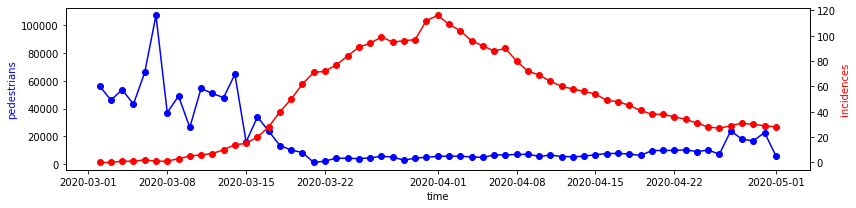

In [9]:
startdate = calcDay("01-03-2020")
enddate = calcDay("01-05-2020")
plottimeframe(startdate, enddate)

In [10]:
test = calcCor(startdate, enddate)
print(test)

[[ 1.         -0.72486853]
 [-0.72486853  1.        ]]


### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz 